# Introduction
The analysis of cardiotocograms (CTG) plays a crucial role in prenatal assessment and fetal monitoring during labor. These recordings provide detailed information about the health and well-being of the fetus, helping healthcare professionals make informed decisions to ensure a safe delivery.

In this portfolio work, I will focus on the construction and evaluation of classification models to predict fetal health using cardiotocogram data. However, instead of utilizing all available variables, I will experiment with those showing high correlation according to Kendall-Tau correlation coefficient, a type of correlation that does not assume a specific distribution in the data. I will compare their metrics with other models whose features will be selected using Pearson correlation, which is more commonly employed. Both approaches allow for the selection of the most relevant features and reduction of the dataset's dimensionality, potentially improving computational efficiency and model interpretability.

I will explore the construction of three distinct classification models: Support Vector Machines (SVM), Random Forest (RF), and Deep Learning or Neural Network (NN). Finally, I will compare their performance using appropriate model evaluation metrics. The objective is to determine which model provides the most accurate and useful predictions for fetal health classification and to identify if the aforementioned correlation type is a valid criterion for feature selection.

In [1]:
#importing dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import random

In [2]:
raw_df = pd.read_csv("fetal_health.csv")
random.seed(28)

In [3]:
#maping response variable for a better manipulation 
raw_df["fetal_health"] = raw_df["fetal_health"].apply(lambda x : int(x))
raw_df["fetal_health"] = raw_df["fetal_health"].map({1:0,2:1,3:2})

In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126 entries, 0 to 2125
Data columns (total 22 columns):
 #   Column                                                  Non-Null Count  Dtype  
---  ------                                                  --------------  -----  
 0   baseline value                                          2126 non-null   float64
 1   accelerations                                           2126 non-null   float64
 2   fetal_movement                                          2126 non-null   float64
 3   uterine_contractions                                    2126 non-null   float64
 4   light_decelerations                                     2126 non-null   float64
 5   severe_decelerations                                    2126 non-null   float64
 6   prolongued_decelerations                                2126 non-null   float64
 7   abnormal_short_term_variability                         2126 non-null   float64
 8   mean_value_of_short_term_variability  

## Initial Analysis of the Response Variable
Analyzing the response variable reveals a significant imbalance between the classes. Specifically, observations corresponding to healthy babies far outnumber those of babies with suspected pathology or confirmed pathology. This imbalance will be addressed and corrected in subsequent stages of the analysis.s.

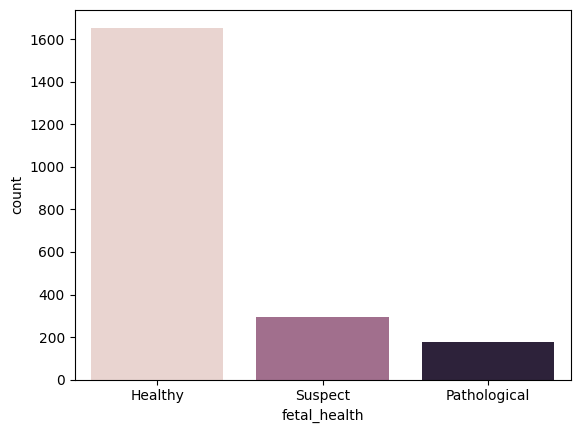

In [6]:
sns.countplot(x= raw_df["fetal_health"],hue =raw_df["fetal_health"], legend=False)
plt.xticks(ticks=plt.xticks()[0], labels = ["Healthy", "Suspect", "Pathological"])
plt.show()

## Feature Selection
As described in the introduction, one of the proposed objectives for developing the models is to extract features with the highest Kendall correlation and compare them with models developed using feature selection based on Pearson correlation. In the following section, this feature extraction will be performed.

<Axes: >

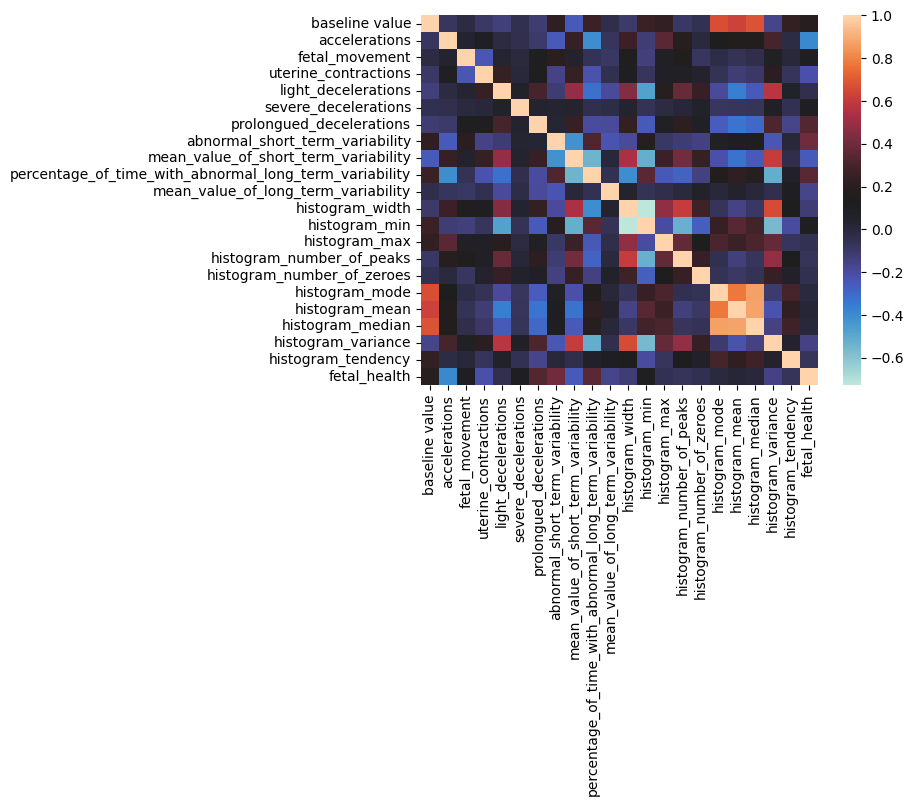

In [7]:
#computación Kendall-Tau and Pearson's correlation
sns.heatmap(raw_df.corr(method="kendall"), cmap="icefire")

<Axes: >

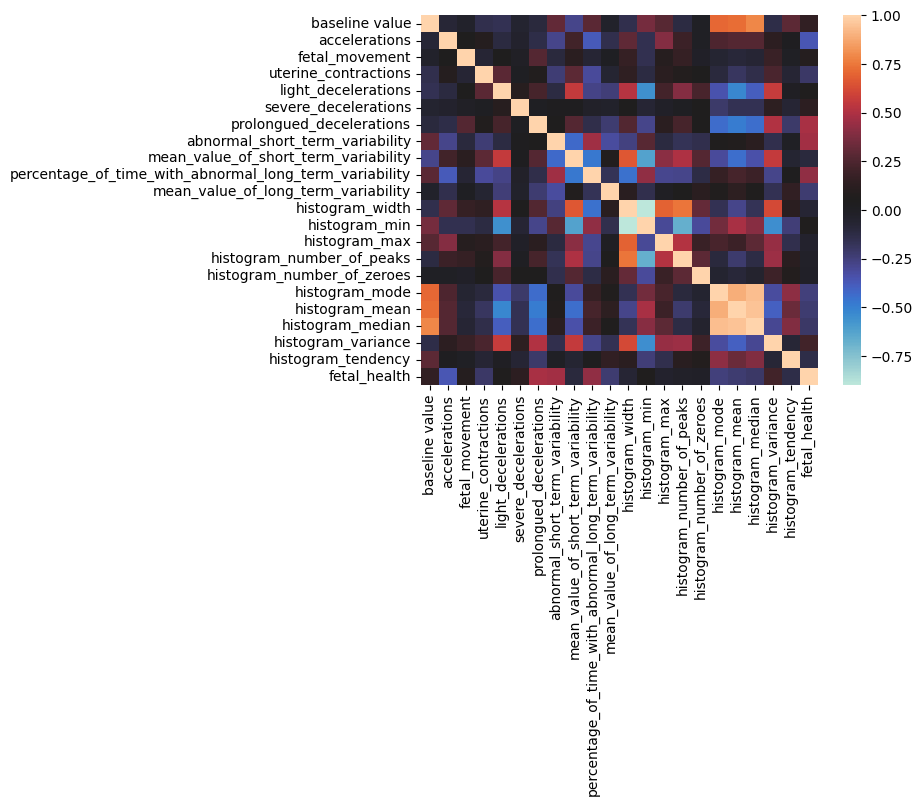

In [8]:
#computación de la correlación de Pearson
sns.heatmap(raw_df.corr(), cmap="icefire")

## Differences in Feature Selection
When performing feature selection, the main difference lies in the observation that using Pearson correlation, the variables histogram_mean, histogram_mode, and histogram_median seem to contribute significantly more to the behavior of the response variable, which in this case is fetal_health.

In [9]:
#Seleccting features accroding to it's correlation
df_kendall = raw_df[["accelerations","uterine_contractions","prolongued_decelerations","abnormal_short_term_variability",
    "percentage_of_time_with_abnormal_long_term_variability","mean_value_of_long_term_variability", "fetal_health"]]
df_pearson = raw_df[["accelerations", "uterine_contractions","prolongued_decelerations","abnormal_short_term_variability","percentage_of_time_with_abnormal_long_term_variability",
                    "mean_value_of_long_term_variability","histogram_mode","histogram_mean", "histogram_median","fetal_health"]]

In [10]:
df_kendall.head()

,accelerations,uterine_contractions,prolongued_decelerations,abnormal_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,fetal_health
0,0.000,0.000,0.0,73.0,43.0,2.4,1
1,0.006,0.006,0.0,17.0,0.0,10.4,0
2,0.003,0.008,0.0,16.0,0.0,13.4,0
3,0.003,0.008,0.0,16.0,0.0,23.0,0
4,0.007,0.008,0.0,16.0,0.0,19.9,0


## Class Balancing and Standardization
In the following section, SMOTE (Synthetic Minority Over-sampling Technique), an algorithm based on K-nearest neighbors, is used to simulate observations with behaviors similar to those presented by each class. This helps to address the class imbalance problem without using resampling methods that could introduce duplicate information. The adjustment was made so that the underrepresented classes have only about 40% less representation than the most represented class, with the intention of not introducing biases into the model. After this, a scaling process was carried out to ensure that all measurements are on a similar scale.

In [11]:
#applying SMOTE and creating data partitions
X_k = df_kendall.drop("fetal_health", axis = 1)
X_p = df_pearson.drop("fetal_health", axis = 1)
y_k= df_kendall["fetal_health"]
y_p= df_pearson["fetal_health"]
sampling = {0:1655, 1:1100, 2:1100}
X_resamp_k, y_resamp_k = SMOTE(sampling_strategy=sampling).fit_resample(X_k, y_k)
X_resamp_p, y_resamp_p = SMOTE(sampling_strategy=sampling).fit_resample(X_p, y_p)

In [12]:
#Data standarization
scaler = StandardScaler()
X_res_k = scaler.fit_transform(X_resamp_k)
X_res_p = scaler.fit_transform(X_resamp_p)

In [13]:
#importing classifiers modules
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import confusion_matrix, classification_report

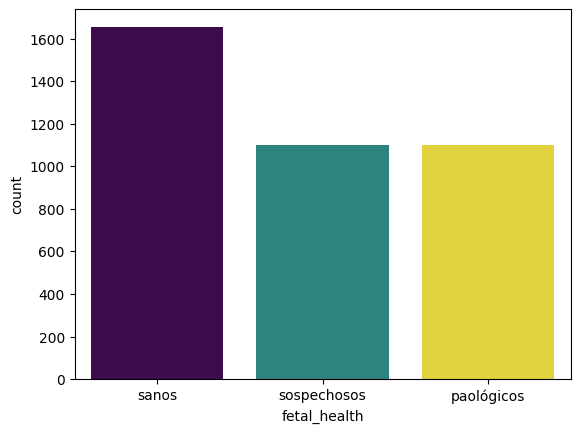

In [14]:
yk_df = pd.DataFrame(y_resamp_k)
yp_df = pd.DataFrame(y_resamp_p)
sns.countplot(x = yp_df["fetal_health"], hue = yp_df["fetal_health"], palette="viridis", legend = False)
plt.xticks(ticks=plt.xticks()[0], labels = ["sanos", "sospechosos", "paológicos"])
plt.show()

## Dataset Division
Now, the dataset will be segmented into training, testing, and validation sets (the latter being particularly useful for the deep learning model). This will enable us to test the created models with data they haven't processed before, allowing us to obtain accurate metrics.

In [15]:
#Creating train and test partitions for both datasets
X_trainK, X_testK, y_trainK, y_testK = train_test_split(X_res_k, y_resamp_k, test_size=0.25)
X_trainp, X_testp, y_trainp, y_testp = train_test_split(X_res_p, y_resamp_p, test_size=0.25)

In [16]:
#Catreing additional partitions datasets for validation for each dataset
X_trainK= X_trainK[:int(len(X_trainK)*0.8)]
XVal_K = X_trainK[int(len(X_trainK)*0.8):]
y_trainK= y_trainK[:int(len(y_trainK)*0.8)]
yVal_K = y_trainK[int(len(y_trainK)*0.8):]
X_trainp= X_trainp[:int(len(X_trainp)*0.8)]
XVal_p = X_trainp[int(len(X_trainp)*0.8):]
y_trainp= y_trainp[:int(len(y_trainp)*0.8)]
yVal_p = y_trainp[int(len(y_trainp)*0.8):]

# Model Generations
In this section the models will be implemented and used for comparation

## Support Vector Machines
In this first classification algorithm, the model with features selected using the Pearson correlation index achieved higher accuracy compared to the model with features selected using the Kendall correlation index. This is evident in the following classification reports:

In [13]:
svm_classifier= SVC(kernel = "poly", random_state=1996)
svm_k = svm_classifier.fit(X_trainK, y_trainK)
SVMK_pred = svm_k.predict(X_testK)

In [14]:
svm_p = svm_classifier.fit(X_trainp, y_trainp)
SVMP_pred = svm_p.predict(X_testp)

In [15]:
print(classification_report(y_testK, SVMK_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       422
           1       0.75      0.80      0.77       293
           2       0.94      0.87      0.91       249

    accuracy                           0.84       964
   macro avg       0.85      0.84      0.85       964
weighted avg       0.85      0.84      0.85       964



In [16]:
print(classification_report(y_testp, SVMP_pred))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       411
           1       0.82      0.82      0.82       273
           2       0.95      0.90      0.93       280

    accuracy                           0.89       964
   macro avg       0.89      0.88      0.89       964
weighted avg       0.89      0.89      0.89       964



## Random Forest
In the following algorithm, a fairly similar performance can be observed between the models generated for both datasets, showing the same accuracy, as can be seen below:

In [17]:
rfor = RandomForestClassifier(n_estimators= 150, random_state= 28)
Rand_fK = rfor.fit(X_trainK, y_trainK)
RFK_pred = Rand_fK.predict(X_testK)

In [18]:
Rand_fP = rfor.fit(X_trainp, y_trainp)
RFP_pred = Rand_fP.predict(X_testp)

In [19]:
print(classification_report(y_testK, RFK_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       416
           1       0.95      0.92      0.93       265
           2       0.98      0.98      0.98       283

    accuracy                           0.96       964
   macro avg       0.96      0.95      0.96       964
weighted avg       0.96      0.96      0.96       964



In [20]:
print(classification_report(y_testp, RFP_pred))

              precision    recall  f1-score   support

           0       0.98      0.95      0.97       416
           1       0.94      0.96      0.95       279
           2       0.99      0.99      0.99       269

    accuracy                           0.97       964
   macro avg       0.97      0.97      0.97       964
weighted avg       0.97      0.97      0.97       964



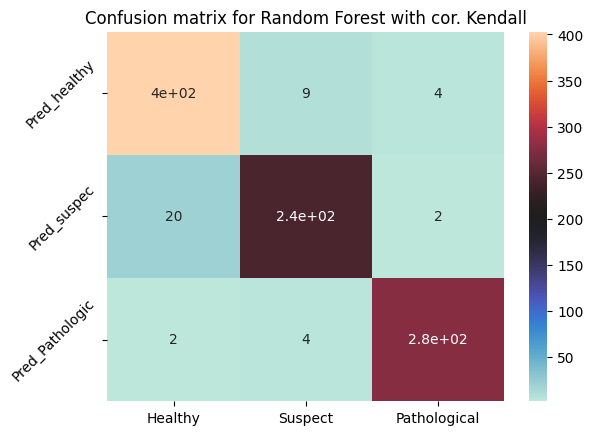

In [21]:
plt.title("Confusion matrix for Random Forest with cor. Kendall")
sns.heatmap(confusion_matrix(y_testK, RFK_pred), cmap="icefire", annot = True)
plt.xticks(ticks= plt.xticks()[0], labels = ["Healthy", "Suspect", "Pathological"])
plt.yticks(ticks = plt.yticks()[0], labels= ["Pred_healthy","Pred_suspec", "Pred_Pathologic"], rotation = 45)
plt.show()

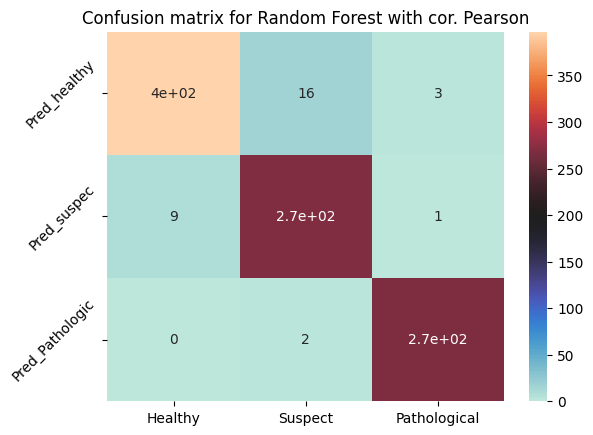

In [22]:
plt.title("Confusion matrix for Random Forest with cor. Pearson")
sns.heatmap(confusion_matrix(y_testp, RFP_pred), cmap="icefire", annot = True)
plt.xticks(ticks= plt.xticks()[0], labels = ["Healthy", "Suspect", "Pathological"])
plt.yticks(ticks = plt.yticks()[0], labels= ["Pred_healthy","Pred_suspec", "Pred_Pathologic"], rotation = 45)
plt.show()

## Deep Learning
In the last model, a neural network was generated with 3 trainable dense layers, meaning that each neuron in each layer is connected to all neurons in the next layer, and 2 dropout layers (non-trainable) that help improve the training process performance, for each dataset. The architecture is defined as follows:

In [23]:
modK = Sequential()
modK.add(Dense(100, activation = "relu", input_shape = (6,)))
modK.add(Dropout(0.3))
modK.add(Dense(50, activation="relu"))
modK.add(Dropout(0.2))                
modK.add(Dense(3, activation="softmax"))
modK.compile(optimizer = "adam", loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
hist_k=modK.fit(X_trainK, y_trainK, epochs=100, batch_size = 30, verbose=0,validation_data=(XVal_K,yVal_K))

C:\Users\Juandi\anaconda3\envs\JD_average\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


The training conducted for the dataset selected with Kendall correlation shows no signs of overfitting, as the learning curve of the validation dataset exhibits a behavior similar to that of the training data learning curve.

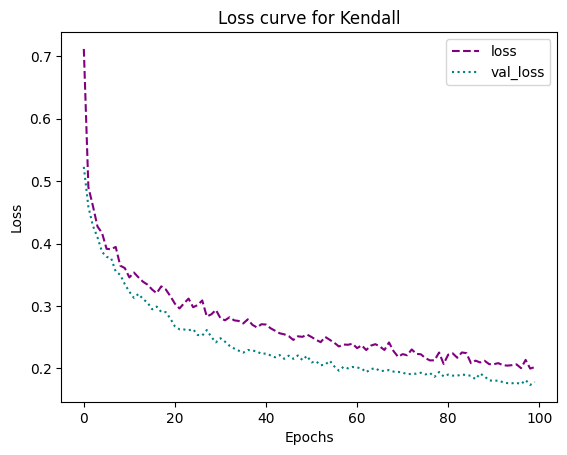

In [24]:
fig = plt.figure()
plt.plot(hist_k.history['loss'], color='purple', label='loss', ls = "--")
plt.plot(hist_k.history['val_loss'], color='teal', label='val_loss', ls = ":")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curve for Kendall')
plt.legend()
plt.show()

In [25]:
modP = Sequential()
modP.add(Dense(100, activation = "relu", input_shape = (9,)))
modP.add(Dropout(0.3))
modP.add(Dense(50, activation="relu"))
modP.add(Dropout(0.2))                
modP.add(Dense(3, activation="softmax"))
modP.compile(optimizer = "adam", loss='sparse_categorical_crossentropy', metrics = ["accuracy"])
hist_p = modP.fit(X_trainp, y_trainp, epochs=100, batch_size = 30, verbose=0, validation_data=(XVal_p, yVal_p))

The curves depicted in the following graph behave similarly to the previously shown learning curves, indicating that there is no overfitting of the model.

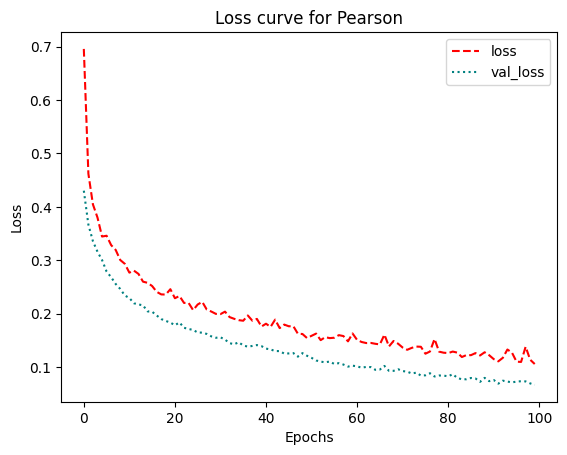

In [26]:
fig = plt.figure()
plt.plot(hist_p.history['loss'], color='red', label='loss', ls = "--")
plt.plot(hist_p.history['val_loss'], color='teal', label='val_loss', ls = ":")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curve for Pearson')
plt.legend()
plt.show()

In [27]:
#making predictions
K_pred = modK.predict(X_testK)
P_pred = modP.predict(X_testp)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [28]:
K_pred=pd.DataFrame(K_pred, columns=["1","2", "3"])
P_pred=pd.DataFrame(P_pred, columns=["1","2", "3"])
K_pred = K_pred.apply(lambda x : round(x))
P_pred = P_pred.apply(lambda x : round(x))

In [29]:
def encode_inverso(df):
    return df.idxmax(axis=1)
K_prNN = encode_inverso(K_pred)
P_prNN = encode_inverso(P_pred)

In [30]:
K_prNN =pd.DataFrame(K_prNN, columns=["fetal_health"])
K_prNN["fetal_health"] = K_prNN["fetal_health"].apply(lambda x: int(x))
K_prNN.value_counts()

fetal_health
1               415
3               280
2               269
Name: count, dtype: int64

In [31]:
P_prNN =pd.DataFrame(P_prNN, columns=["fetal_health"])
P_prNN["fetal_health"] = P_prNN["fetal_health"].apply(lambda x: int(x))
P_prNN.value_counts()

fetal_health
1               395
2               301
3               268
Name: count, dtype: int64

In [32]:
#transforming response variable to it's original value for creating a confusion matrix and classification report
y_testp= pd.DataFrame(y_testp,columns=["fetal_health"])
y_testK= pd.DataFrame(y_testK,columns=["fetal_health"])
y_testK["fetal_health"] = y_testK["fetal_health"].map({0:1, 1:2, 2:3})
y_testp["fetal_health"] = y_testp["fetal_health"].map({0:1, 1:2, 2:3})

The classification reports for the deep learning models applied to both datasets show that the dataset selected with Pearson correlation performed slightly better. The results are as follows:

In [33]:
print(classification_report(y_testK, K_prNN))

              precision    recall  f1-score   support

           1       0.92      0.92      0.92       416
           2       0.87      0.89      0.88       265
           3       0.98      0.97      0.97       283

    accuracy                           0.92       964
   macro avg       0.92      0.92      0.92       964
weighted avg       0.92      0.92      0.92       964



In [34]:
print(classification_report(y_testp, P_prNN))

              precision    recall  f1-score   support

           1       0.99      0.94      0.96       416
           2       0.90      0.97      0.94       279
           3       0.98      0.97      0.98       269

    accuracy                           0.96       964
   macro avg       0.96      0.96      0.96       964
weighted avg       0.96      0.96      0.96       964



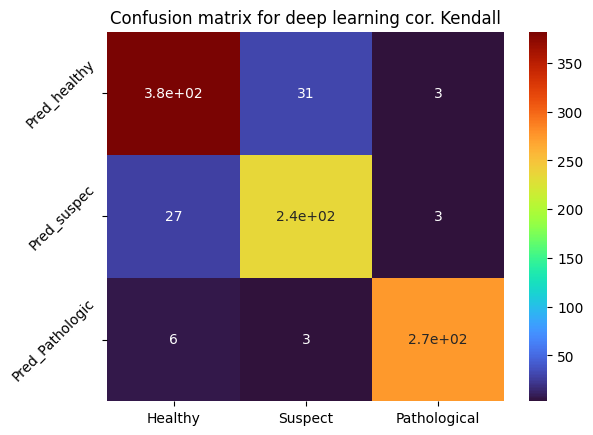

In [35]:
plt.title("Confusion matrix for deep learning cor. Kendall")
sns.heatmap(confusion_matrix(y_testK, K_prNN), cmap="turbo", annot = True)
plt.xticks(ticks= plt.xticks()[0], labels = ["Healthy", "Suspect", "Pathological"])
plt.yticks(ticks = plt.yticks()[0], labels= ["Pred_healthy","Pred_suspec", "Pred_Pathologic"], rotation = 45)
plt.show()

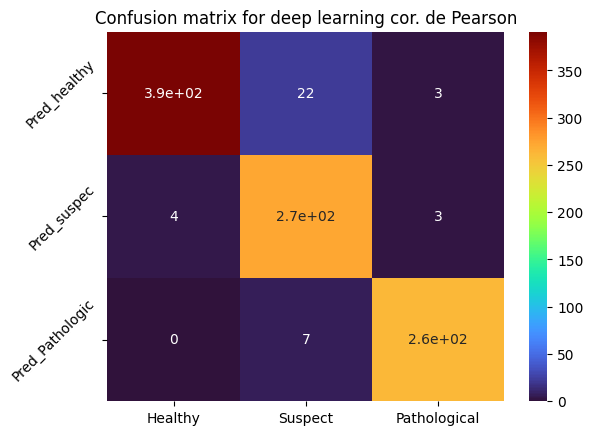

In [36]:
plt.title("Confusion matrix for deep learning cor. de Pearson")
sns.heatmap(confusion_matrix(y_testp, P_prNN), cmap="turbo", annot = True)
plt.xticks(ticks= plt.xticks()[0], labels = ["Healthy", "Suspect", "Pathological"])
plt.yticks(ticks = plt.yticks()[0], labels= ["Pred_healthy","Pred_suspec", "Pred_Pathologic"], rotation = 45)
plt.show()

## Conclusions
In this portfolio work, an exhaustive analysis was conducted using a dataset of cardiotocograms with the aim of selecting the most relevant predictor variables and building efficient predictive models. Two different correlation methods were employed: Pearson and Kendall. Subsequently, three different models were developed and evaluated: SVM (Support Vector Machines), Random Forest, and a Deep Learning model.

### Evaluation of Correlation Methods
Pearson Correlation: This method measures the linear relationship between variables and is sensitive to direct linear relationships. It was observed that variables selected using Pearson correlation provided an optimized dataset for predictive modeling.

Kendall Correlation: This method measures the ordinal association between variables, being more robust against non-normal distributions and non-linear relationships. Although this approach is useful in certain contexts, in this particular case, it did not outperform the performance achieved with Pearson correlation.

### Model Performance
Following variable selection, three predictive models were constructed and evaluated using standard metrics. The main observations were:

SVM (Support Vector Machines): This model demonstrated robust accuracy on both datasets (Pearson and Kendall), though slightly better performance was observed on the dataset selected using Pearson correlation.

Random Forest: Similar to SVM, the Random Forest model exhibited higher accuracy and stability in predictions when using the dataset selected with Pearson correlation.

Deep Learning: The Deep Learning model proved to be the most sensitive to the quality of selected variables, achieving its best performance with the dataset based on Pearson correlation.

### Final Conclusion
The comparison of correlation methods and predictive models revealed that variable selection based on Pearson correlation provided a more suitable dataset for predictive modeling in the context of this study. The SVM, Random Forest, and Deep Learning models all performed slightly better with variables selected using Pearson correlation.

This finding suggests that, for this specific dataset of cardiotocograms, the linear relationship between variables captured by Pearson correlation is more relevant and useful for developing effective predictive models. However, it is important to consider that the efficacy of variable selection methods may vary depending on the dataset and application domain. Therefore, future research could explore hybrid combinations of correlation methods or the application of more advanced feature selection techniques to further improve predictive performance. rendimiento predictivo.